
# Logistic Regression


In [7]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from test_xgboost import perf_parse


def lr_trainer():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1], random_state=1)
    
    since = time.time()
    # Standard preprocess the training data
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    lr_model = LogisticRegression(max_iter=20000)
    lr_model.fit(x_train, y_train)
    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))
    
    predictions = lr_model.predict(x_train)
    cm_perf = (confusion_matrix(y_train, predictions))
    print("Confusion matrix: \n", cm_perf)
    perf = perf_parse(cm_perf)
    
    print("LR train score: {0:.3f}".format(lr_model.score(x_train, y_train)))
    print("LR test score: {0:.3f}".format(lr_model.score(x_test, y_test)))

    return lr_model


lr_model = lr_trainer()
joblib.dump(lr_model, 'lr.model')

Training complete in 3.66s
Confusion matrix: 
 [[74707  2461]
 [ 3348 38233]]
Acc: 0.951, Precision: 0.940 Recall: 0.919
LR train score: 0.951
LR test score: 0.952


['lr.model']


# SVM

Using a common way SVM to do the binary classification job.


In [1]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from test_xgboost import perf_parse


def svm_trainer():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1], random_state=1)
    
    since = time.time()
    # Standard preprocess the training data
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))
    
    predictions = svm_model.predict(x_train)
    cm_perf = (confusion_matrix(y_train, predictions))
    print("Confusion matrix: \n", cm_perf)
    perf = perf_parse(cm_perf)
    
    print("SVM train score: {0:.3f}".format(svm_model.score(x_train, y_train)))
    print("SVM test score: {0:.3f}".format(svm_model.score(x_test, y_test)))
    
    return svm_model

svm_model = svm_trainer()
joblib.dump(svm_model, 'svm.model')

/Users/johnpaul/opt/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Training complete in 161.92s
Confusion matrix: 
 [[77027   141]
 [  143 41438]]
Acc: 0.998, Precision: 0.997 Recall: 0.997
SVM train score: 0.998
SVM test score: 0.998


['svm.model']


# The neural network


In [3]:

import numpy as np
import pandas as pd
import copy
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


def load_Dataset():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1], random_state=1)

    # Standard preprocess the training data
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x_train, y_train, x_test, y_test


def my_pca(x_train, x_test, k):
    x_train_mean = torch.mean(x_train, dim=0)
    x_train_reduced = x_train - x_train_mean

    Sigma = torch.mm(x_train_reduced.t(), x_train_reduced) / \
        len(x_train_reduced)

    u, s, v = torch.svd(Sigma)
    score = torch.sum(s[0:k]) / torch.sum(s)
    u_reduced = u[:, 0:k]

    x_train_reduced = torch.mm(x_train_reduced, u_reduced)

    x_test_mean = torch.mean(x_test, dim=0)
    x_test_reduced = x_test - x_test_mean

    x_test_reduced = torch.mm(x_test_reduced, u_reduced)
    return x_train_reduced, x_test_reduced, score

# Accuracy


def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

# Multilayer Perceptron


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], num_classes)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in))
        a_2 = F.relu(self.fc2(a_1))
        y_pred = self.fc3(a_2)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred


def train_model(pca_bool=False, pca_num=10):
    # Load Dataset
    x_train, y_train, x_test, y_test = load_Dataset()
    score = 100
    if pca_bool:
        x_train, x_test, score = my_pca(x_train, x_test, pca_num)
    # Device configuration
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    # Model configuration
    [m_train, n_train] = x_train.shape
    input_size = n_train
    hidden_size = [60, 30]
    num_classes = 2
    # Train configuration
    num_epochs = 1000
    learning_rate = 0.01
    dropout_p = 0.5
    step_size = 500

    model = MLP(input_size=input_size,
                hidden_size=hidden_size,
                num_classes=num_classes)

    model = model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    # Optimization
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Training
    for t in range(num_epochs):
        # Forward pass
        y_pred = model(x_train)

        # Accuracy
        _, predictions = y_pred.max(dim=1)
        accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

        # Loss
        loss = loss_fn(y_pred, y_train)

        if t % 10 == 0:
            _, pred_test = model(x_test, apply_softmax=True).max(dim=1)
            test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
            # deep copy the model
            if test_acc > best_acc:
                best_acc = test_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if t % 500 == 0:
                print("epoch: {0:4d} | loss: {1:.4f} | Train accuracy: {2:.1f}% | Test accuracy: {3:.1f}%"
                      .format(t, loss, accuracy, test_acc))

        # Zero all gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))
    #print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    # Predictions
    _, pred_train = model(x_train, apply_softmax=True).max(dim=1)
    _, pred_test = model(x_test, apply_softmax=True).max(dim=1)

    # Train and test accuracies
    train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
    test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
    print("train acc: {0:.1f}%, test acc: {1:.1f}%".format(
        train_acc, test_acc))

    y_true = y_test.cpu().numpy()
    y_pred = pred_test.cpu().numpy()

    cm_perf = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    print(report)
    acc = (cm_perf[1, 1] + cm_perf[0, 0]) / np.sum(cm_perf)
    recall = cm_perf[1, 1] / (cm_perf[1, 0] + cm_perf[1, 1])
    precision = cm_perf[1, 1] / (cm_perf[0, 1] + cm_perf[1, 1])
    score = 2 / ((1 / recall) + (1 / precision))
    model_perf = torch.tensor([acc, precision, recall, score])

    return model, model_perf


train_model()


epoch:    0 | loss: 0.7166 | Train accuracy: 35.5% | Test accuracy: 35.6%
epoch:  500 | loss: 0.0002 | Train accuracy: 100.0% | Test accuracy: 100.0%
Training complete in 3m 8s
train acc: 100.0%, test acc: 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25682
           1       1.00      1.00      1.00     13902

    accuracy                           1.00     39584
   macro avg       1.00      1.00      1.00     39584
weighted avg       1.00      1.00      1.00     39584



(MLP(
   (fc1): Linear(in_features=45, out_features=60, bias=True)
   (fc2): Linear(in_features=60, out_features=30, bias=True)
   (fc3): Linear(in_features=30, out_features=2, bias=True)
 ), tensor([0.9999, 0.9999, 0.9998, 0.9999]))


# Xgboost



In [9]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

def CART_trainer():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1])
    
    since = time.time()

    cart_model = DecisionTreeClassifier().fit(x_train, y_train)
    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))
    
    predictions = cart_model.predict(x_train)
    cm_perf = (confusion_matrix(y_train, predictions))
    print("Confusion matrix: \n", cm_perf)
    perf = perf_parse(cm_perf)
    
    return cart_model

cart_model = CART_trainer()
joblib.dump(cart_model, 'cart.model')

Training complete in 1.40s
Confusion matrix: 
 [[76953     0]
 [    0 41796]]
Acc: 1.000, Precision: 1.000 Recall: 1.000


['cart.model']

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

def GBDT_trainer():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1], random_state=6)
    
    since = time.time()

    GBDT_model = DecisionTreeClassifier().fit(x_train, y_train)
    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))
    
    predictions = GBDT_model.predict(x_train)
    cm_perf = (confusion_matrix(y_train, predictions))
    print("Confusion matrix: \n", cm_perf)
    perf = perf_parse(cm_perf)
    
    return GBDT_model

GBDT_model = GBDT_trainer()
joblib.dump(GBDT_model, 'GBDT.model')


Training complete in 1.41s
Confusion matrix: 
 [[77175     0]
 [    0 41574]]
Acc: 1.000, Precision: 1.000 Recall: 1.000


['GBDT.model']

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import time

def xgb_trainer():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1], random_state=1)
    
    since = time.time()
    param = {'max_depth': 2}
    xgb_model = xgb.XGBClassifier(param)
    xgb_model.fit(x_train, y_train)
    
    
    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))
    
    predictions = xgb_model.predict(x_train)
    cm_perf = (confusion_matrix(y_train, predictions))
    print("Confusion matrix: \n", cm_perf)
    perf = perf_parse(cm_perf)
    
    return xgb_model

xgb_model = xgb_trainer()
xgb_model.save_model('xgb.model')


[0]	eval-error:0.06869	train-error:0.06890
[1]	eval-error:0.04628	train-error:0.04690
[2]	eval-error:0.02286	train-error:0.02385
[3]	eval-error:0.01794	train-error:0.01812
[4]	eval-error:0.01291	train-error:0.01309
[5]	eval-error:0.00867	train-error:0.00908
[6]	eval-error:0.00652	train-error:0.00665
[7]	eval-error:0.00430	train-error:0.00443
[8]	eval-error:0.00364	train-error:0.00356
[9]	eval-error:0.00374	train-error:0.00331
[10]	eval-error:0.00311	train-error:0.00277
[11]	eval-error:0.00237	train-error:0.00227
[12]	eval-error:0.00321	train-error:0.00323
[13]	eval-error:0.00235	train-error:0.00216
[14]	eval-error:0.00187	train-error:0.00168
[15]	eval-error:0.00152	train-error:0.00145
[16]	eval-error:0.00164	train-error:0.00141
[17]	eval-error:0.00157	train-error:0.00138
[18]	eval-error:0.00129	train-error:0.00112
[19]	eval-error:0.00124	train-error:0.00112
[20]	eval-error:0.00121	train-error:0.00098
[21]	eval-error:0.00096	train-error:0.00089
[22]	eval-error:0.00109	train-error:0.0009

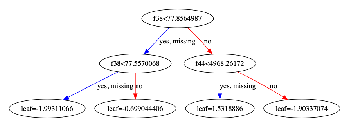

Training complete in 17.79s
[ True False False ... False False False]
Confusion matrix: 
 [[25680     2]
 [    4 13898]]
Acc: 1.000, Precision: 1.000 Recall: 1.000


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import time
from test_xgboost import perf_parse


def xgb_trainer():
    dataset = np.load('satellite_state.npy')
    X = dataset[:, :-1]
    y = dataset[-1]
    x_train, x_test, y_train, y_test = train_test_split(
        dataset[:, :-1], dataset[:, -1], random_state=1)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)

    evallist = [(dtest, 'eval'), (dtrain, 'train')]

    since = time.time()
    num_round = 100

    param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
    xgb_model = xgb.train(param, dtrain, num_round, evallist)
    #xgb_model.fit(x_train, y_train)

    xgb.plot_tree(xgb_model, num_trees=0)
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.2f}s'.format(time_elapsed))

    predictions = xgb_model.predict(dtest)
    predictions = np.array(predictions > 0.5)
    print(predictions)
    cm_perf = (confusion_matrix(y_test, predictions))
    print("Confusion matrix: \n", cm_perf)
    perf = perf_parse(cm_perf)

    return xgb_model


xgb_model = xgb_trainer()
# xgb_model.save_model('xgb.model')

In [30]:
xgb_model.save_model('xgb.model')